FNB FRAUD DECTECTION MODEL

In [725]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import random 
seed = 16
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

p = lambda x="" : print(x)

In [726]:
dataset = pd.read_csv("FNB Fraud Case Study Dataset.csv")

# Data preprocessing 

In [727]:
dataset

,transaction_id,user_id,amount,transaction_channel,merchant,device_id,card_type,country,timestamp,prev_timestamp,...,distance_from_last_tx,km_per_min,device_change,velocity_last_10min,is_night,merchant_risk_score,account_age_days,prior_chargebacks,high_risk_country,is_fraud
0,1,U0328,194.88,in-store,DesignerHub,DV0013,debit,ZA,2025-01-01 01:16:15,2025-01-01 00:00:00,...,388.030491,5.088924,1,9,1,1,704,0,0,0
1,2,U0072,450.62,online,Supermart,DV0045,prepaid,ZA,2025-01-01 01:57:10,2025-01-01 01:16:15,...,186.300192,4.553162,0,8,1,1,902,0,0,0
2,3,U0048,47.97,card-not-present,DesignerHub,DV0120,virtual,KE,2025-01-01 02:55:11,2025-01-01 01:57:10,...,2786.633412,48.031601,0,1,1,2,166,0,0,0
3,4,U0367,299.68,card-not-present,ShoeWorld,DV0113,prepaid,UK,2025-01-01 03:10:09,2025-01-01 02:55:11,...,6793.310565,453.896029,0,8,1,1,1841,0,0,0
4,5,U0415,116.58,airtime,ShoeWorld,DV0082,prepaid,ZA,2025-01-01 04:09:50,2025-01-01 03:10:09,...,8319.755133,139.398299,0,8,1,1,934,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,U0467,694.07,card-not-present,Clicks,DV0201,prepaid,UK,2025-10-18 16:53:38,2025-10-18 15:30:42,...,9005.478173,108.586955,1,9,0,1,1562,0,0,0
9996,9997,U0186,57.98,in-store,EasyPay,DV0161,debit,NG,2025-10-18 17:09:10,2025-10-18 16:53:38,...,5027.586066,323.664339,0,1,0,2,972,0,1,0
9997,9998,U0448,122.71,card-present,LuxuryHub,DV0113,prepaid,UK,2025-10-18 17:12:55,2025-10-18 17:09:10,...,5022.563713,1339.350324,0,7,0,2,1615,0,0,0
9998,9999,U0222,266.51,in-store,GameStore,DV0181,virtual,NG,2025-10-18 17:56:31,2025-10-18 17:12:55,...,5026.593192,115.288835,0,9,0,2,854,0,1,0


In [728]:
dataset.columns

Index(['transaction_id', 'user_id', 'amount', 'transaction_channel',
       'merchant', 'device_id', 'card_type', 'country', 'timestamp',
       'prev_timestamp', 'lat', 'lon', 'prev_lat', 'prev_lon',
       'time_since_last_tx', 'distance_from_last_tx', 'km_per_min',
       'device_change', 'velocity_last_10min', 'is_night',
       'merchant_risk_score', 'account_age_days', 'prior_chargebacks',
       'high_risk_country', 'is_fraud'],
      dtype='str')

In [729]:
dataset = dataset.drop(columns=['transaction_id',              
       'device_id', 'timestamp',
       'prev_timestamp','time_since_last_tx','km_per_min', 'is_night',
       'high_risk_country'])

In [730]:
str_cols = ['user_id', 'merchant', 'country', 'card_type', 'transaction_channel']

for col in str_cols:
    dataset[col] = dataset[col].astype("category").cat.codes

In [731]:
TrainDataset = pd.concat([dataset[dataset['is_fraud']==0][:1000], dataset[dataset['is_fraud']==1][:400]], ignore_index=True)

In [732]:
TestDataset = pd.concat([dataset[dataset['is_fraud']==0][1000:], dataset[dataset['is_fraud']==1][400:]], ignore_index=True)

In [733]:
TrainDataset

,user_id,amount,transaction_channel,merchant,card_type,country,lat,lon,prev_lat,prev_lon,distance_from_last_tx,device_change,velocity_last_10min,merchant_risk_score,account_age_days,prior_chargebacks,is_fraud
0,327,194.880000,3,2,1,3,-22.988850,26.496871,-25.254599,29.408572,388.030491,1,9,1,704,0,0
1,71,450.620000,4,10,2,3,-24.439300,27.422112,-22.988850,26.496871,186.300192,0,8,1,902,0,0
2,47,47.970000,1,2,3,0,-0.904823,36.634389,-24.439300,27.422112,2786.633412,0,1,2,166,0,0
3,366,299.680000,1,9,2,2,52.144534,0.247320,-0.904823,36.634389,6793.310565,0,8,1,1841,0,0
4,414,116.580000,0,9,2,3,-19.131131,27.266937,52.144534,0.247320,8319.755133,0,8,1,934,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,359,114.850000,1,6,2,1,6.368327,3.224508,7.149854,3.790635,106.709242,1,8,2,618,0,1
1396,353,158.340000,4,5,0,3,-27.386855,28.685591,7.168288,3.920146,4662.018499,1,5,1,876,0,1
1397,496,28.520000,2,11,0,0,-0.526155,37.283605,51.674376,0.414228,6739.898873,1,7,2,938,0,1
1398,166,2562.316145,3,10,0,3,-25.930593,26.748207,-21.207103,21.060092,781.362692,0,15,2,372,0,1


In [734]:
TrainDataset = TrainDataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [735]:
X = TrainDataset.drop(columns='is_fraud')
X_t = TestDataset.drop(columns='is_fraud')

In [736]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_t)

In [737]:
xtest = X_test
xtrain = X_

In [738]:
ytrain = list(TrainDataset["is_fraud"])
ytest = list(TestDataset["is_fraud"])

In [739]:
ytrain.count(1)
ytest.count(0)


8500

# Data loaders

In [740]:
def exact_datasets(ytrain_labels, xtrain_examples, ytest, xtest, batchsize = 32, shuffle = False):
    
    xtrian_len = len(xtrain_examples)
    train = xtrian_len * .7

    train_dataset  = TensorDataset(torch.tensor(xtrain_examples[:int(train)], dtype=torch.float), torch.tensor(ytrain_labels[:int(train)]))
    train_dataloader = DataLoader(dataset = train_dataset, batch_size=batchsize, shuffle=shuffle)
    
    val_dataset  = TensorDataset(torch.tensor(xtrain_examples[int(train):], dtype=torch.float), torch.tensor(ytrain_labels[int(train):]))
    val_dataloader = DataLoader(dataset = val_dataset, batch_size=batchsize, shuffle=False)
    
    test_dataset  = TensorDataset(torch.tensor(xtest, dtype=torch.float), torch.tensor(ytest))
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=batchsize, shuffle=False)
    

    return train_dataloader, val_dataloader, test_dataloader, len(xtrain_examples[0])

In [741]:
train_dl, val_dl, test_dl, _ = exact_datasets(ytrain_labels=ytrain, xtrain_examples=xtrain, ytest=ytest, xtest=xtest, shuffle=True)

In [742]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes) # Dimension of data point X (input_ size) , num_classes is output size [(fraud) 1 or (not fraud) 0] 

    def forward(self, datapoint):
        output = self.linear(datapoint)
        return output
    
    def compute_probabilities(self, inputs):
        outputs = self.forward(inputs)
        probabilities = torch.softmax(outputs, dim =1)
        return probabilities # tensor 


    def predict(self, inputs):
        probabilities = self.compute_probabilities(inputs)

        predictions = []
        for example in probabilities:
            example = list(example)
            pred = example.index(max(example))
            predictions.append(pred)

        return predictions


    # For the training and validation set only
    def calc_accuracy(self, data_loader):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for datapoints, labels in data_loader:
                outputs = self(datapoints)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return 100 * correct / total
    

## Training loop

Here we seek to train our models :
**. An objective function for learning, like cross-entropy loss.**
   - The cross-entropy loss function given by $-\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}\log(\hat{y}_{ik})$, where $N$ is the number of samples, $K$ is the number of classes, $y_{ik}$ is a binary indicator of whether class $k$ is the correct classification for the $i$-th sample, and $\hat{y}_{ik}$ is the predicted probability that the $i$-th sample belongs to class $k$.

**. An algorithm for optimizing the objective function, stochastic gradient descent (SGD).**

The updates are made for each training sample or a batch of samples, leading to the update rules: $\mathbf{W} \leftarrow \mathbf{W} - \alpha \nabla_{\mathbf{W}}\mathcal{L}$ and $\mathbf{b} \leftarrow \mathbf{b} - \alpha \nabla_{\mathbf{b}}\mathcal{L}$, where $\alpha$ is the learning rate, $\nabla_{\mathbf{W}}\mathcal{L}$ and $\nabla_{\mathbf{b}}\mathcal{L}$ are the gradients of the loss function with respect to $\mathbf{W}$ and $\mathbf{b}$, respectively.


In [743]:
def train_model(train_dl, val_dl, input_size, num_epochs =50, learning_rate = 0.01):

    num_classes = 2 # (0 or 1)

    model = LogisticRegression(input_size, num_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    validation_loss = []
    Train_loss = []

    for epoch in range(num_epochs):

        for i, (datapoints, labels) in enumerate(train_dl):
            outputs = model(datapoints)
            labels = labels.long()
            loss = F.cross_entropy(outputs, labels) # training loss

            # optimization 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0.0
        val_total = 0

        with torch.no_grad():
            for val_data, val_labels in val_dl:
                
                val_outputs = model(val_data)
                val_labels = val_labels.long()

                batch_loss = F.cross_entropy(val_outputs, val_labels)
                val_loss += batch_loss.item() * val_labels.size(0)
                val_total += val_labels.size(0)

        avg_val_loss = val_loss / val_total

        t_loss = loss.item()
        Train_loss.append(t_loss)
        validation_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {t_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    return model, Train_loss, validation_loss

In [744]:
epochs = 100

In [745]:
trained_model, train_loss, validation_loss = train_model(train_dl, val_dl, len(X_[0]), epochs, 0.01)

Epoch 1, Train Loss: 0.8749, Val Loss: 0.7889
Epoch 2, Train Loss: 0.6096, Val Loss: 0.7164
Epoch 3, Train Loss: 0.5603, Val Loss: 0.6631
Epoch 4, Train Loss: 0.7966, Val Loss: 0.6245
Epoch 5, Train Loss: 0.5466, Val Loss: 0.5971
Epoch 6, Train Loss: 0.5333, Val Loss: 0.5767
Epoch 7, Train Loss: 0.7476, Val Loss: 0.5620
Epoch 8, Train Loss: 0.5144, Val Loss: 0.5504
Epoch 9, Train Loss: 0.5722, Val Loss: 0.5421
Epoch 10, Train Loss: 0.4342, Val Loss: 0.5353
Epoch 11, Train Loss: 0.4011, Val Loss: 0.5299
Epoch 12, Train Loss: 0.6015, Val Loss: 0.5260
Epoch 13, Train Loss: 0.4555, Val Loss: 0.5224
Epoch 14, Train Loss: 0.4941, Val Loss: 0.5195
Epoch 15, Train Loss: 0.5280, Val Loss: 0.5174
Epoch 16, Train Loss: 0.5681, Val Loss: 0.5154
Epoch 17, Train Loss: 0.4729, Val Loss: 0.5142
Epoch 18, Train Loss: 0.4615, Val Loss: 0.5130
Epoch 19, Train Loss: 0.3907, Val Loss: 0.5120
Epoch 20, Train Loss: 0.5984, Val Loss: 0.5111
Epoch 21, Train Loss: 0.5993, Val Loss: 0.5103
Epoch 22, Train Loss: 

Testing 

In [746]:
def plotter(trian_loss, validation_loss, epochs):
    plt.Figure(figsize=(12,8))
    
    plt.title(f"Fraud Dectection Model\nTrain and Validation loss Vs. Epochs")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.ylabel("Cross Entropy Loss")
    plt.plot([x for x in range(1,epochs + 1)], trian_loss, "-.", label = "Training loss")
    plt.plot([x for x in range(1, epochs + 1)], validation_loss, "r--", label = "Validation loss")
    plt.legend()
    plt.show()



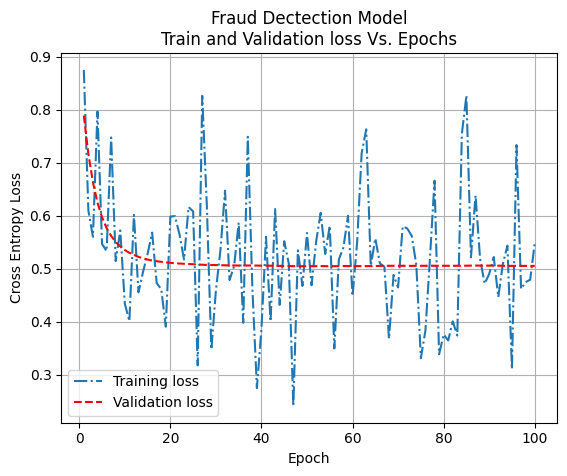

In [747]:
plotter(train_loss, validation_loss, epochs)

In [748]:
trained_model

LogisticRegression(
  (linear): Linear(in_features=16, out_features=2, bias=True)
)

Confusion matrix for detection model, and evaluting these metrices: 
● Accuracy 
● Precision 
● Recall 
● F1 

In [749]:
def get_predictions(model, dataloader):
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
    return y_pred, y_true

In [750]:
ypred, ytrue = get_predictions(trained_model, test_dl)

In [751]:
ytrue.count(1)

100

In [752]:
ypred.count(1)

963

In [753]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def show_metrics(ytrue, ypred, title="Confusion Matrix"):

    category = {
0:"Not Fraud",
1:"Fraud"

}    
    labels = np.unique(ytrue)

    # Confusion matrix
    cm = confusion_matrix(ytrue, ypred, labels=labels)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)



    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Activity")
    plt.ylabel("True Activity")
    plt.title(title)
    plt.show()

    # Metrics
    print("\nPer-class accuracy:")
    for i, acc in enumerate(class_accuracies):
        print(f" for {category.get(labels[i])}: {acc:.3f}")
    print("Accuracy:", accuracy_score(ytrue, ypred))
    print("\nPer-class metrics:\n")
    print(classification_report(ytrue, ypred, digits=3))

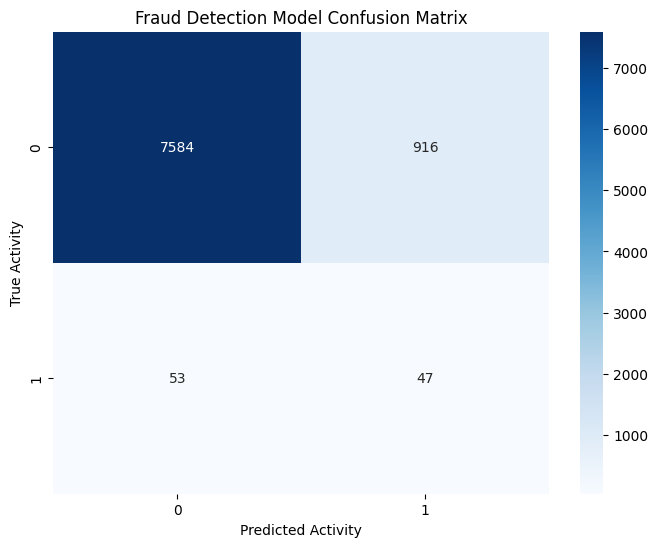


Per-class accuracy:
 for Not Fraud: 0.892
 for Fraud: 0.470
Accuracy: 0.8873255813953488

Per-class metrics:

              precision    recall  f1-score   support

           0      0.993     0.892     0.940      8500
           1      0.049     0.470     0.088       100

    accuracy                          0.887      8600
   macro avg      0.521     0.681     0.514      8600
weighted avg      0.982     0.887     0.930      8600



In [754]:
show_metrics(ytrue, ypred, title="Fraud Detection Model Confusion Matrix")